In [1]:
"""
    -- Description:
        
        This notebook deals with the following problems in financial labeling:
        
        (1) using fixed threshold for return rate often leads to training data imbalance         
        
        under circumstances of various volatility.
        
        (2) path dependent labeling needs to be applied where we havce profit-taking 
        
        and stop-loss orders placed.
        
    -- Prerequisite:
        
        Quandl Api Key
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        September 17, 2020
    
""";

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import time
from contextlib import contextmanager

%matplotlib inline
sns.set()
quandl.ApiConfig.api_key = "okePP6eysAeuyx8BnX7k"

In [27]:
# Util function for recording execution duration
@contextmanager
def how_long(process_name):
    startTime = time.time()
    yield
    elapsedTime = time.time() - startTime
    print("[{}] finished in {}s".format(process_name, int(elapsedTime)))

## Load Historical Data

In [4]:
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2018-01-01")
data = quandl.get("WIKI/AAPL.11", start_date=start_date, end_date=end_date)
data = data.reset_index(drop=False)

In [7]:
def get_return_and_ewm_volatility(df, span=100):
    df["Return"] = df["Adj. Close"] / df["Adj. Close"].shift(1) - 1
    df["Volatility"] = df["Return"].ewm(span=span).std()
    return None

In [8]:
get_return_and_ewm_volatility(data)

In [9]:
data.head(3).append(data.tail(3))

,Date,Adj. Close,Return,Volatility
0,2015-01-02,103.863957,NaN,NaN
1,2015-01-05,100.937944,-0.028172,NaN
2,2015-01-06,100.947444,0.000094,0.019987
750,2017-12-27,170.600000,0.000176,0.011438
751,2017-12-28,171.080000,0.002814,0.011328
752,2017-12-29,169.230000,-0.010814,0.011336


## Three Barrier Labeling

In [ ]:
# We choose a date (D), and then fix the range for the next h days (D, D + h) 
# For each day in the range, we check if the acc. return rate triggers  pt/sl
# The pt/sl thresholds are given by (1) the volatility on the date D and (2) width

In [45]:
def TBL(data, width=(0.5, 0.5), h=15):
    """
    Input: Historical Close Data
    Output: Data with Labels by Three Barrier Labeling method
    """
    # Set barriers
    events = data[["Date", "Volatility"]].copy()
    events["VB for Date"] = events["Date"] + pd.Timedelta(days=h)
    events["UB for Return"] = events["Volatility"] * width[0]
    events["LB for Return"] = events["Volatility"] * (- width[1])
    events["Last Date"] = list(events["Date"])[-1]
    
    # Get Labels
    result = events[["Date", "VB for Date", "Last Date"]].copy()
    for idx, date, vb, _ in result.itertuples():
        upper_bound = events.at[idx, "UB for Return"]
        lower_bound = events.at[idx, "LB for Return"]
        tmp = data[(data["Date"] > date)&(data["Date"]<vb)][["Date", "Adj. Close"]].copy()
        base_price = data[data["Date"]==date]["Adj. Close"].iloc[0]
        tmp["Return"] = tmp["Adj. Close"] / base_price - 1
        # upper and lower bound touching
        ut_date = tmp[tmp["Return"] > upper_bound]["Date"].min()
        dt_date = tmp[tmp["Return"] < lower_bound]["Date"].min()
        result.at[idx, "UT Date"] = ut_date
        result.at[idx, "DT Date"] = dt_date
    
    result["First Touch"] = result[["VB for Date","UT Date","DT Date","Last Date"]].dropna(how="all").min(axis=1)
    return result

In [76]:
def get_labels(data, result, enable_zero_label=True):
    """
    Input: Historical Data, TBL result
    Output: Final Labels
        (1) when enable_zero_label is True:
            1: Upper Bound Triggered
           -1: Lower Bound Triggered
            0: Vertical Bound Triggered
        (2) when enable_zero_label is False:
            1: positive return
           -1: negative return
            0: zero return
    """
    output = result.copy()
    price_start = pd.merge(result, data, on=["Date"], how="left")["Adj. Close"]
    price_end = pd.merge(result, data, left_on="First Touch", right_on="Date", how="left")["Adj. Close"]
    
    output["Return"] = (price_end / price_start - 1)
    output = output.dropna(subset=["Return"]).reset_index(drop=True)
    output["Label"] = np.sign(output["Return"]).astype("int")
    if enable_zero_label:
        for i, content in output.iterrows():
            if content["First Touch"] == min(content["VB for Date"], content["Last Date"]):
                output.at[i, "Label"] = 0
    return output

In [77]:
with how_long("TBL Labeling"):
    result = TBL(data, (2, 2), 15)
    result_with_labels = get_labels(data, result, True)

[TBL Labeling] finished in 4s


In [74]:
result_with_labels.head(3).append(result_with_labels.head(3))

,Date,VB for Date,Last Date,UT Date,DT Date,First Touch,Return,Label
0,2015-01-05,2015-01-20,2017-12-29,NaT,NaT,2015-01-20,0.023247,0
1,2015-01-06,2015-01-21,2017-12-29,2015-01-08,NaT,2015-01-08,0.052983,1
2,2015-01-07,2015-01-22,2017-12-29,NaT,NaT,2015-01-22,0.043155,0
3,2015-01-08,2015-01-23,2017-12-29,NaT,NaT,2015-01-23,0.009742,0
4,2015-01-09,2015-01-24,2017-12-29,NaT,2015-01-16,2015-01-16,-0.053745,-1
...,...,...,...,...,...,...,...,...
701,2017-12-22,2018-01-06,2017-12-29,NaT,2017-12-26,2017-12-26,-0.025370,-1
702,2017-12-26,2018-01-10,2017-12-29,NaT,NaT,2017-12-29,-0.007856,0
703,2017-12-27,2018-01-11,2017-12-29,NaT,NaT,2017-12-29,-0.008030,0
704,2017-12-28,2018-01-12,2017-12-29,NaT,NaT,2017-12-29,-0.010814,0


<AxesSubplot:xlabel='Label', ylabel='count'>

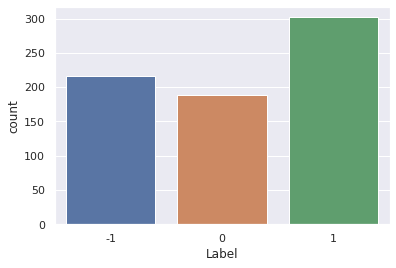

In [75]:
sns.countplot(result_with_labels["Label"])